In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from glob import glob
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print(os.listdir("../input/skin-cancer-mnist-ham10000"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [3]:
#Matching the row info in HAM10000_metadata with corresponding images
img_dir = '../input/skin-cancer-mnist-ham10000'
image_path = glob(os.path.join(img_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_path}

In [4]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
### Returns categorical values and turns them into integer codes
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [9]:
df.shape

(10015, 10)

In [10]:
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Vascular lesions':5,
    'Melanoma':6,
}

In [11]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [12]:
## We replace the null values with mean age
df['age'].fillna((df['age'].mean()), inplace = True)

In [13]:
 img_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [14]:
img_data.sample(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
4912,242,169,172,242,166,165,239,162,158,235,...,234,173,173,225,160,151,229,167,156,4
743,15,12,13,54,43,50,117,100,115,159,...,35,26,30,9,8,9,5,5,5,2
9253,67,44,32,112,81,71,142,105,99,149,...,41,27,29,7,3,3,9,3,0,4
198,0,0,0,0,0,0,6,6,5,15,...,33,22,24,9,9,8,1,1,1,2
224,194,175,194,204,185,202,208,190,208,214,...,213,201,224,208,194,218,197,179,202,2
2476,70,39,46,130,95,99,171,139,152,190,...,219,184,206,214,180,202,200,167,189,1
5858,222,140,141,226,146,153,224,147,155,225,...,204,130,122,202,130,123,200,128,121,4
4938,216,127,132,215,126,132,221,135,143,219,...,207,129,123,204,125,120,198,118,110,4
1794,189,170,173,190,171,175,195,177,181,198,...,199,182,183,194,174,174,191,171,172,6
2971,178,158,167,181,160,173,172,150,164,174,...,174,154,155,154,135,134,106,88,89,1


In [15]:
## Rescale the images
img_rescale = img_data/255

In [16]:
img_rescale.shape

(10015, 2353)

In [17]:
## Number of null values
img_rescale.isnull().sum()


pixel0000    0
pixel0001    0
pixel0002    0
pixel0003    0
pixel0004    0
            ..
pixel2348    0
pixel2349    0
pixel2350    0
pixel2351    0
label        0
Length: 2353, dtype: int64

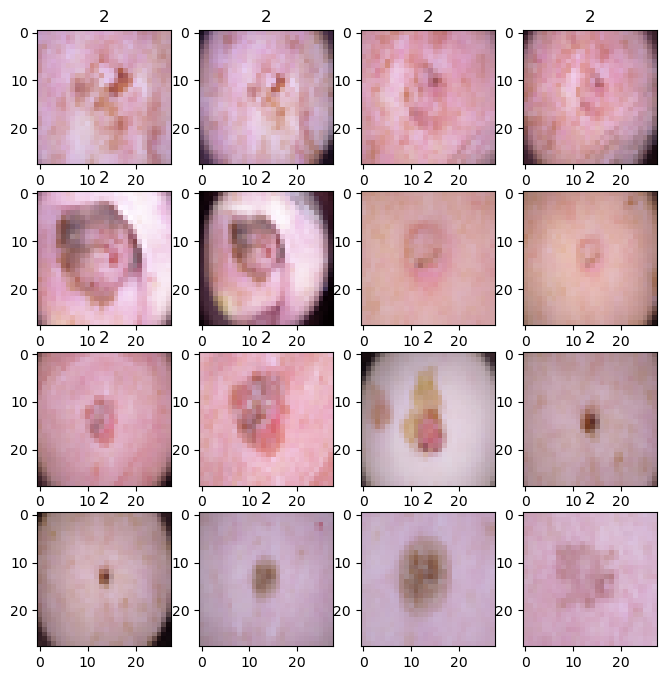

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img_rescale.iloc[i, :2352].values.reshape(28,28,3))
    plt.title(img_data.iloc[i,2352])

In [19]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [20]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [21]:
df['image'].map(lambda x: x.shape).value_counts()

(100, 100, 3)    10015
Name: image, dtype: int64

In [22]:
from tensorflow.keras.utils import to_categorical

features = df.drop(columns = ['cell_type_idx'], axis = 1)
label = df['cell_type_idx']

In [23]:
from sklearn.model_selection import train_test_split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(features, label, test_size = 0.2)

In [24]:
x_train = np.asarray(X_train_data['image'].tolist())
x_test = np.asarray(X_test_data['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

X_train = (x_train - x_train_mean)/x_train_std
X_test = (x_test - x_test_mean)/x_test_std

In [25]:
X_train

array([[[[ 1.51358059e+00, -2.12618229e-01,  1.32621535e-01],
         [ 1.51358059e+00, -2.55773199e-01,  4.63115944e-02],
         [ 1.51358059e+00, -2.55773199e-01,  2.47341091e-02],
         ...,
         [ 8.23101064e-01, -1.11887261e+00, -9.24675242e-01],
         [ 1.40569317e+00, -4.71548052e-01, -2.98928170e-01],
         [ 1.42727065e+00, -2.55773199e-01, -1.47885773e-01]],

        [[ 1.49200311e+00, -1.91040743e-01,  8.94665649e-02],
         [ 1.51358059e+00, -2.12618229e-01,  8.94665649e-02],
         [ 1.53515808e+00, -2.98928170e-01,  3.15662388e-03],
         ...,
         [ 6.72058667e-01, -1.05414015e+00, -9.03097757e-01],
         [ 6.93636152e-01, -1.20518255e+00, -9.67830213e-01],
         [ 1.34096071e+00, -4.71548052e-01, -3.42083140e-01]],

        [[ 1.42727065e+00, -2.98928170e-01, -6.15758319e-02],
         [ 1.49200311e+00, -3.42083140e-01, -3.99983466e-02],
         [ 1.55673556e+00, -2.98928170e-01,  2.47341091e-02],
         ...,
         [ 1.36253820e+0

In [26]:
y_train = to_categorical(y_train_data, num_classes = 7)
y_test = to_categorical(y_test_data, num_classes = 7)

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization

In [28]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 256)      1024      
 hNormalization)                                                 
                                                        

In [30]:
from tensorflow.keras.optimizers import Adam
EarlyStop = keras.callbacks.EarlyStopping(
               min_delta = 0.001,
               patience = 10 ,
               verbose = 0
)

optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None)

model.compile(
    optimizer =optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [31]:
# from sklearn.model_selection import train_test_split

# Combine X_train and y_train into a single array
#data = list(zip(X_train, y_train))

# Randomize the order of samples
#random_state = 42  # Set a random seed for reproducibility
#np.random.shuffle(data)

# Unzip the shuffled data into separate X_train and y_train arrays
#X_train, y_train = zip(*data)

# Split the data into training and validation sets
#test_size = 0.1
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            learning_rate=0.00001)

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine X_train and y_train into a single array
data = list(zip(X_train, y_train))

# Remove samples with missing values
data = [(x, y) for x, y in data if x is not None and y is not None]

# Unzip the preprocessed data into separate X_train and y_train arrays
X_train, y_train = zip(*data)

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Define the random state for reproducibility
random_state = 42

# Split the data into training and validation sets
test_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [35]:
print(X_train.shape)
print(X_test.shape)

(6489, 100, 100, 3)
(2003, 100, 100, 3)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = 7  # Replace with the actual number of classes in your problem

# Define your model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)))  # Use X_train_normalized.shape[1] as the input shape
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create a new model that outputs the features from a desired layer
layer_index = 1  # Replace with the desired index of the layer (zero-based index)
feature_extractor = Sequential(model.layers[0:layer_index])

# Extract features from the training set
train_features = feature_extractor.predict(X_train_reshaped)

# Extract features from the test set
test_features = feature_extractor.predict(X_valid_reshaped)


NameError: name 'X_train_normalized' is not defined

In [ ]:
epochs = 10
batch_size = 32
history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid_reshaped, y_valid))

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# epochs = 500
# batch_size = 32
# #datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
# #datagen.fit(X_train)

# history = model.fit(X_train,y_train, epochs = epochs,
#                     batch_size=batch_size,
# #callbacks = [EarlyStop, learning_rate_reduction],
#                     callbacks = [EarlyStop],
#                     validation_data = (X_valid, y_valid))

In [ ]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()